In [1]:
import control as ct, numpy as np, matplotlib.pyplot as plt
from json import load, dump

# Funções de transferência do controlador PID discreto:
# $$G_c(z) = K_p + \frac{K_i}{1-z^{-1}} + K_d\cdot(1-z^-1)$$

# $$G_c(z) = K_C \cdot \frac{(z-z_{c1})\cdot(z-z_{c2})}{z\cdot(z-1)}$$

In [2]:
def create_servo(k, tau):
    return k*ct.tf(1, [1, 0])*ct.tf(1, [tau, 1])

In [3]:
def plot_response(sys, t, u, display = True):
    response = ct.forced_response(ct.feedback(sys), t, u)
    if display:
        plt.grid()
        plt.plot(response.time, response.outputs)
        plt.show()
    return response

In [4]:
def compare_step(sys, time, y_min = None, y_max = None, labels = []):
    COLORS = ("b", "r", "g", "c", "m", "y", "k", "w")

    step = np.ones(len(time))
    resp = [plot_response(s, time, step, display=False) for s in sys]
    plt.grid()
    for i, r in enumerate(resp):
        if i == 0:
            plt.plot(r.time, r.outputs, c=COLORS[i%len(COLORS)], label=labels[i] if len(labels) == len(sys) else "Não compensado")
        else:
            plt.plot(r.time, r.outputs, c=COLORS[i%len(COLORS)], label=labels[i] if len(labels) == len(sys) else f"Compensado {i}")
    plt.legend()
    if y_min != None:
        plt.ylim(bottom=y_min)
    if y_max != None:
        plt.ylim(top=y_max)
    plt.show()
    return resp

In [5]:
def design_pid_computational(*, sys: ct.TransferFunction, ts: float, overshoot: float,
                            discrete: bool = False, T: float = None,
                            k_range: tuple = (1.5, 10), k_step: float = 0.2,
                            a_range: tuple = (0.5, 2.5), a_step: float = 0.1,
                            method: str = "bilinear"):
    
    if discrete and T == None:
        raise Exception(ValueError)
    
    k_vals = np.arange(k_range[0], k_range[1]+k_step, k_step)
    a_vals = np.arange(a_range[0], a_range[1]+a_step, a_step)

    for k in k_vals:
        for a in a_vals:
            gc = k*ct.tf([1, 2*a, a**2], [1, 0])
            stats = ct.step_info(ct.feedback(gc*sys))
            if stats["Overshoot"]/100 <= overshoot and stats["SettlingTime"] <= ts:
                if not discrete:
                    return sys, gc
                kp = 2*k*a
                ki = k*a**2
                kd = k
                if method == "bilinear":
                    # bilinear transform -> s = 2/T*(z-1)/(z+1)
                    return ct.c2d(sys, T), ct.tf([kp+ki*T/2+2*kd/T, ki*T-4*kd/T, -kp+ki*T/2+2*kd/T], [1, 0, -1], T)
                elif method == "forward":
                    # forward difference euler's method -> s = (z-1)/T
                    return ct.c2d(sys, T), kp + ct.tf([kd, -kd], [T], T) + ct.tf(ki*T, [1, -1], T)
                elif method == "backward":
                    # backawrd difference approximation -> s = (z-1)/(zT)
                    return ct.c2d(sys, T), kp + ct.tf([ki*T, 0], [1, -1], T) + kd*ct.tf([1, -1], [T, 0], T)

    return sys, None

In [6]:
def design_lead_cancel(*, sys, csi=None, ts=None, pole=None, overshoot=None, verbose=False):
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    elif pole != None:
        dom_s = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    if verbose:
        print(f"Polo dominante escolhido: {dom_s:.2f}")
    zc = np.sort(sys.poles()[np.abs(sys.poles()) > 10e-5])[0] # zero = polo mais próximo da origem sem ser 0
    current_angle = 0
    for p in sys.poles()[sys.poles() != zc]:
        current_angle += np.angle(dom_s - p)
    for z in sys.zeros():
        current_angle += np.angle(dom_s - z)

    pole_angle = np.pi - current_angle
    if pole_angle < np.pi/2: # polo do compensador à esquerda do polo dominante
        pc = dom_s.real - dom_s.imag/np.tan(pole_angle)
    else: # polo do compensador à direita do compensador
        pc = dom_s.real + dom_s.imag/np.tan(pole_angle)
    gc = ct.tf([1, -zc], [1, -pc])
    k = 1/np.abs((gc*sys)(dom_s))
    return sys, k*gc

In [7]:
def design_lead_bissect(*, sys, csi=None, ts=None, pole=None, overshoot=None, verbose=False) -> tuple[ct.TransferFunction, ct.TransferFunction]:
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    elif pole != None:
        dom_s = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    if verbose:
        print(f"Polo dominante escolhido: {dom_s:.2f}")
    current_angle = 0
    for p in sys.poles():
        current_angle += np.angle(dom_s - p)
        
    for z in sys.zeros():
        current_angle += np.angle(dom_s - z)
    
    current_angle %= 2*np.pi

    # resolvendo para zc e pc
    phi = np.abs(np.pi - current_angle)
    alpha = np.angle(dom_s) - np.pi/2
    beta = np.pi/2 - alpha
    gamma = np.pi - beta
    theta = np.pi - beta - (gamma+phi)/2
    eta = np.pi - beta - (gamma-phi)/2
    pc = -np.abs(dom_s)*np.sin((gamma+phi)/2)/(np.sin(theta))
    zc = -np.abs(dom_s)*np.sin((gamma-phi)/2)/(np.sin(eta))
    
    gc = ct.tf([1, -zc], [1, -pc])
    k = 1/np.abs((gc*sys)(dom_s))
    
    return sys, k*gc

In [8]:
def z2t(sys, out_prefix = "uN", in_prefix = "errN"):

    out = [{
            "coef": coef,
            "iter": i
        } for i, coef in enumerate(sys.den[0][0].real) if coef != 0]
    
    inp = [{
            "coef": coef,
            "iter": i
        } for i, coef in enumerate(sys.num[0][0].real) if coef != 0]
    
    if len(inp) < len(out):
        for entry in inp:
            entry["iter"] += 1

    lhs = (str(out[0]["coef"])+'*' if out[0]["coef"] != 1 else "") + out_prefix + "_" + str(out[0]["iter"])

    rhs = ""
    for term in out[1:]:
        rhs += str("{0:+}".format(-term["coef"])) + f"*{out_prefix}_{term['iter']} "

    for term in inp:
        rhs += str("{0:+}".format(term["coef"])) + f"*{in_prefix}_{term['iter']} "

    return (lhs + " = " + rhs).replace("= +", "= ").replace(" +", " + ").replace(" -", " - ").strip()

In [9]:
def s2t(sys, out_prefix = "u", in_prefix = "err"):

    out = [{
            "coef": coef,
            "diff": i
        } for i, coef in enumerate(reversed(sys.den[0][0])) if coef != 0]
    
    inp = [{
            "coef": coef,
            "diff": i
        } for i, coef in enumerate(reversed(sys.num[0][0])) if coef != 0]

    if len(inp) > len(out):
        for entry in inp:
            entry["diff"] += 1

    lhs = (str(out[0]["coef"])+'*' if out[0]["coef"] != 1 else "") + out_prefix + "_" + str(out[0]["diff"])
    rhs = ""
    for term in out[:-1]:
        rhs += str("{0:+}".format(-term["coef"])) + f"*{out_prefix}_{term['diff']} "

    for term in inp:
        rhs += str("{0:+}".format(term["coef"])) + f"*{in_prefix}_{term['diff']} "
    return (lhs + " = " + rhs).strip()

# Função de transferência do controlador PID:
# $$G_c(s) = K\cdot\frac{(s+a)^2}{s}$$
# Função de transferência do compensador por avanço de fase:
# $$G_c(s) = K\cdot\frac{s+z_c}{s+p_c}$$

In [10]:
y_min = 0
overshoot = 0.1
ts = 2
T = 5e-3

### Motor panorâmico

In [11]:
path = "../system_parameters/"
with open(f"{path}motor_pan.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [12]:
pan = create_servo(K, tau)
pan

TransferFunction(array([0.64206706]), array([0.14737725, 1.        , 0.        ]))

### Controle PID

In [13]:
_, gz_pan = design_pid_computational(sys=pan, overshoot=overshoot, ts=ts, discrete=True, method="backward", T=T)
gz_pan

TransferFunction(array([ 2.56289063, -5.0625    ,  2.5       ]), array([ 0.005, -0.005,  0.   ]), 0.005)

In [14]:
pan_z = ct.c2d(pan, 5e-3)

In [15]:
time = np.arange(0, 5, 5e-3)

In [16]:
nc = ct.step_info(ct.feedback(pan_z))

print(f"Não compensado:\nTempo de acomodação:{nc['SettlingTime']}\nOvershoot:{nc['Overshoot']:.2f}%\nUndershoot:{nc['Undershoot']:.2f}%")
print(50*"-")

c = ct.step_info(ct.feedback(gz_pan*pan_z))
print(f"Compensado:\nTempo de acomodação:{c['SettlingTime']}\nOvershoot:{c['Overshoot']:.2f}%\nUndershoot:{c['Undershoot']:.2f}%")

Não compensado:
Tempo de acomodação:5.615
Overshoot:0.00%
Undershoot:0.00%
--------------------------------------------------
Compensado:
Tempo de acomodação:1.945
Overshoot:9.10%
Undershoot:0.00%


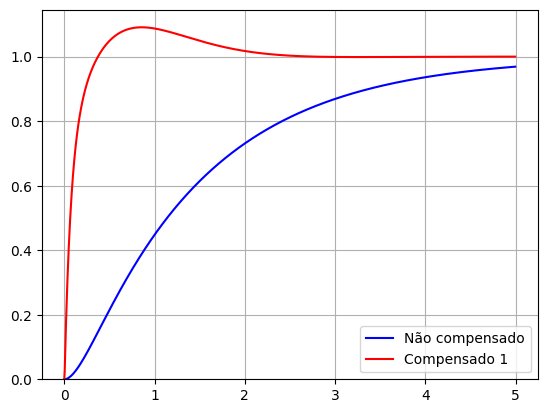

In [17]:
_ = compare_step([pan_z, gz_pan*pan_z], time, y_min=y_min)

In [18]:
diff_eq = z2t(gz_pan)
print(diff_eq)

consts = {
    "output": [-float(coef) if gz_pan.den[0][0][0] == 1 else -float(coef) / gz_pan.den[0][0][0] for coef in gz_pan.den[0][0][1:]],
    "input": [float(coef) if gz_pan.den[0][0][0] == 1 else float(coef) / gz_pan.den[0][0][0] for coef in gz_pan.num[0][0]]
    }
with open("../system_parameters/controller_pan.info", "w") as file:
    dump(consts, file)

0.005*uN_0 = 0.005*uN_1 + 2.562890625*errN_0 - 5.0625*errN_1 + 2.5*errN_2


### Avanço de fase pelo método da bissecção

In [19]:
_, gc_pan = design_lead_bissect(sys=pan, overshoot=overshoot, ts=ts)
gc_pan

TransferFunction(array([ 5.31434759, 14.47280508]), array([1.       , 4.2029522]))

In [20]:
gz_pan = ct.c2d(gc_pan, 5e-3)
gz_pan

TransferFunction(array([ 5.31434759, -5.24273863]), array([ 1.        , -0.97920451]), 0.005)

In [21]:
time = np.arange(0, 5, 1e-3)

In [22]:
nc = ct.step_info(ct.feedback(pan))

print(f"Não compensado:\nTempo de acomodação:{nc['SettlingTime']}\nOvershoot:{nc['Overshoot']:.2f}%\nUndershoot:{nc['Undershoot']:.2f}%")
print(50*"-")

c = ct.step_info(ct.feedback(gc_pan*pan))
print(f"Compensado:\nTempo de acomodação:{c['SettlingTime']}\nOvershoot:{c['Overshoot']:.2f}%\nUndershoot:{c['Undershoot']:.2f}%")

Não compensado:
Tempo de acomodação:5.640146544040771
Overshoot:0.00%
Undershoot:0.00%
--------------------------------------------------
Compensado:
Tempo de acomodação:1.8830501085671192
Overshoot:0.00%
Undershoot:0.00%


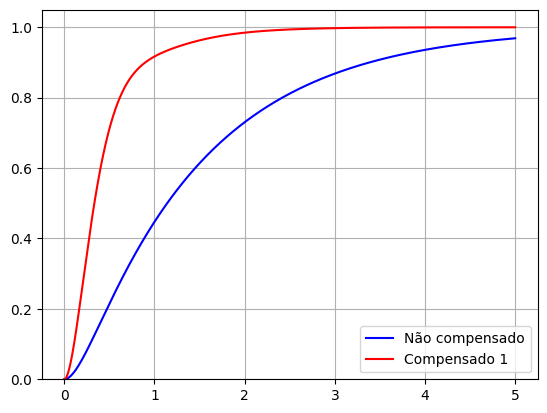

In [23]:
_ = compare_step([pan, gc_pan*pan], time, y_min=y_min)

In [24]:
diff_eq = z2t(gz_pan)
print(diff_eq)

consts = {
    "output": [-float(coef) if gz_pan.den[0][0][0] == 1 else -float(coef) / gz_pan.den[0][0][0] for coef in gz_pan.den[0][0][1:]],
    "input": [float(coef) if gz_pan.den[0][0][0] == 1 else float(coef) / gz_pan.den[0][0][0] for coef in gz_pan.num[0][0]]
    }
with open("../system_parameters/controller_pan.info", "w") as file:
    dump(consts, file)

uN_0 = 0.9792045104124105*uN_1 + 5.314347593844756*errN_0 - 5.242738626445766*errN_1


### Motor tilt

In [25]:
path = "../system_parameters/"
with open(f"{path}motor_tilt.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [26]:
tilt = create_servo(K, tau)
tilt

TransferFunction(array([0.51245659]), array([0.14464497, 1.        , 0.        ]))

### Controle PID

In [27]:
_, gz_tilt = design_pid_computational(sys=tilt, overshoot=overshoot, ts=ts, discrete=True, method="backward", T=T)
gz_tilt

TransferFunction(array([ 3.17798437, -6.2775    ,  3.1       ]), array([ 0.005, -0.005,  0.   ]), 0.005)

In [28]:
tilt_z = ct.c2d(tilt, 5e-3)

In [29]:
time = np.arange(0, 5, 5e-3)

In [30]:
nc = ct.step_info(ct.feedback(tilt_z))

print(f"Não compensado:\nTempo de acomodação:{nc['SettlingTime']}\nOvershoot:{nc['Overshoot']:.2f}%\nUndershoot:{nc['Undershoot']:.2f}%")
print(50*"-")

c = ct.step_info(ct.feedback(gz_tilt*tilt_z))
print(f"Compensado:\nTempo de acomodação:{c['SettlingTime']}\nOvershoot:{c['Overshoot']:.2f}%\nUndershoot:{c['Undershoot']:.2f}%")

Não compensado:
Tempo de acomodação:7.175
Overshoot:0.00%
Undershoot:0.00%
--------------------------------------------------
Compensado:
Tempo de acomodação:1.96
Overshoot:9.11%
Undershoot:0.00%


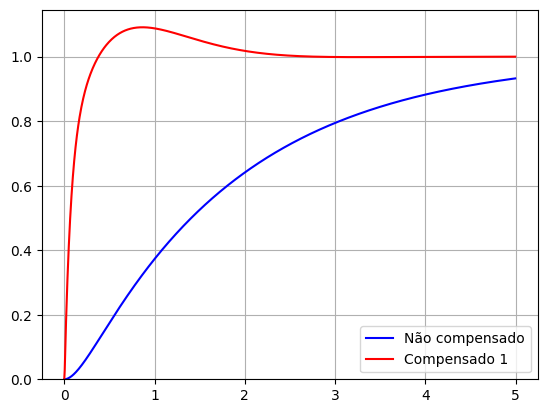

In [31]:
_ = compare_step([tilt_z, gz_tilt*tilt_z], time, y_min=y_min)

In [32]:
diff_eq = z2t(gz_tilt)
print(diff_eq)

consts = {
    "output": [-float(coef) if gz_tilt.den[0][0][0] == 1 else -float(coef) / gz_tilt.den[0][0][0] for coef in gz_tilt.den[0][0][1:]],
    "input": [float(coef) if gz_tilt.den[0][0][0] == 1 else float(coef) / gz_tilt.den[0][0][0] for coef in gz_tilt.num[0][0]]
    }
with open("../system_parameters/controller_tilt.info", "w") as file:
    dump(consts, file)

0.005*uN_0 = 0.005*uN_1 + 3.1779843749999994*errN_0 - 6.277499999999999*errN_1 + 3.0999999999999996*errN_2


### Avanço de fase pelo método da bissecção

In [33]:
_, gc_tilt = design_lead_bissect(sys=tilt, overshoot=overshoot, ts=ts)
gc_tilt

TransferFunction(array([ 6.70809238, 18.15796045]), array([1.        , 4.22852766]))

In [34]:
gz_tilt = ct.c2d(gc_tilt, 5e-3)
gz_tilt

TransferFunction(array([ 6.70809238, -6.61825562]), array([ 1.       , -0.9790793]), 0.005)

In [35]:
time = np.arange(0, 5, 1e-3)

In [36]:
nc = ct.step_info(ct.feedback(tilt))

print(f"Não compensado:\nTempo de acomodação:{nc['SettlingTime']}\nOvershoot:{nc['Overshoot']:.2f}%\nUndershoot:{nc['Undershoot']:.2f}%")
print(50*"-")

c = ct.step_info(ct.feedback(gc_tilt*tilt))
print(f"Compensado:\nTempo de acomodação:{c['SettlingTime']}\nOvershoot:{c['Overshoot']:.2f}%\nUndershoot:{c['Undershoot']:.2f}%")

Não compensado:
Tempo de acomodação:7.260483462808637
Overshoot:0.00%
Undershoot:0.00%
--------------------------------------------------
Compensado:
Tempo de acomodação:1.8833895647291112
Overshoot:0.00%
Undershoot:0.00%


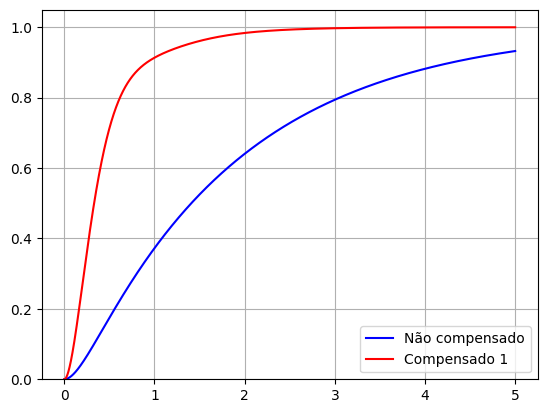

In [37]:
_ = compare_step([tilt, gc_tilt*tilt], time, y_min=y_min)

In [38]:
diff_eq = z2t(gz_tilt)
print(diff_eq)

consts = {
    "output": [-float(coef) if gz_tilt.den[0][0][0] == 1 else -float(coef) / gz_tilt.den[0][0][0] for coef in gz_tilt.den[0][0][1:]],
    "input": [float(coef) if gz_tilt.den[0][0][0] == 1 else float(coef) / gz_tilt.den[0][0][0] for coef in gz_tilt.num[0][0]]
    }
with open("../system_parameters/controller_tilt.info", "w") as file:
    dump(consts, file)

uN_0 = 0.9790793003839892*uN_1 + 6.708092377937437*errN_0 - 6.6182556152627825*errN_1
